![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!!

In [1]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/19 17:09:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


👌 Launched gpu optimized session with with: 🚀Spark-NLP==6.1.3, 💊Spark-Healthcare==6.1.1, 🕶Spark-OCR==6.1.0, running on ⚡ PySpark==3.4.0


In [2]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *

from IPython.display import display, Markdown

import pkg_resources

## Read image


    Image #0:
    Origin: file:/usr/local/lib/python3.12/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: 10
    Number of channels: 1


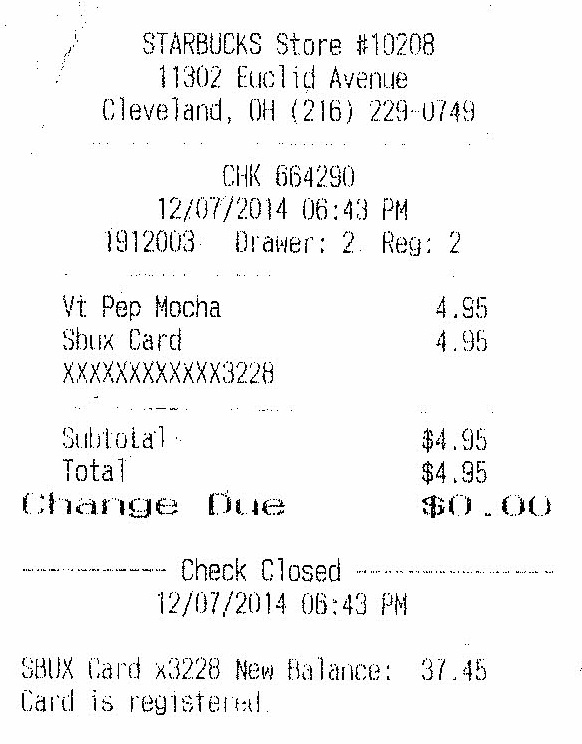

In [3]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')

image_example_df = spark.read.format("binaryFile").load(image_path)

display_images(BinaryToImage().transform(image_example_df))

## Scaling

In [9]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

scaler = ImageTransformer() \
        .addScalingTransform(2) \
        .setInputCol("image") \
        .setOutputCol("scaled_image") \
        .setImageType(ImageType.TYPE_BYTE_GRAY)

scaler_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler
])

In [11]:
result = scaler_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'scaled_image',
 'exception']

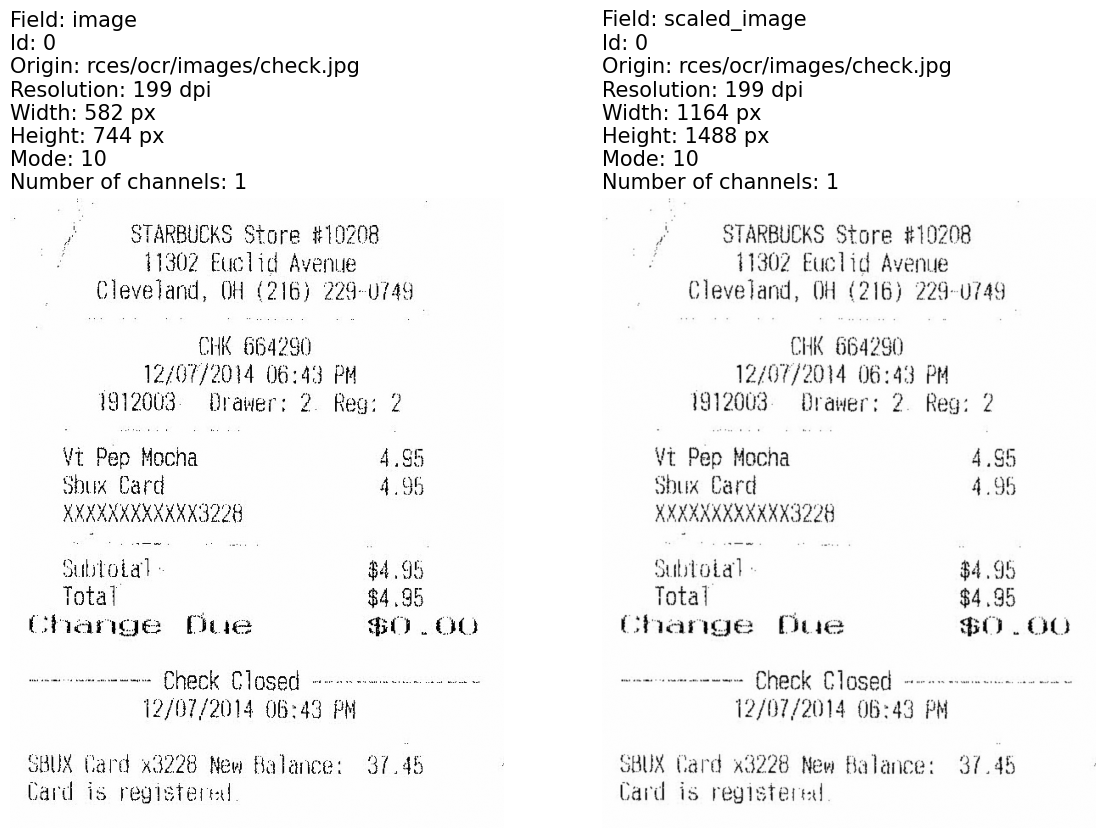

In [13]:
display_images_horizontal(result, "image,scaled_image")

## Image Adaptive Thresholding

In [16]:
binary_to_image = BinaryToImage()\
      .setInputCol("content") \
      .setOutputCol("image")

threshold = ImageTransformer() \
        .addAdaptiveThreshold(21, 20)\
        .setInputCol("image") \
        .setOutputCol("thresholded_image")

threshold_pipeline = PipelineModel(stages=[
    binary_to_image,
    threshold
])

In [17]:
result = threshold_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'thresholded_image',
 'exception']

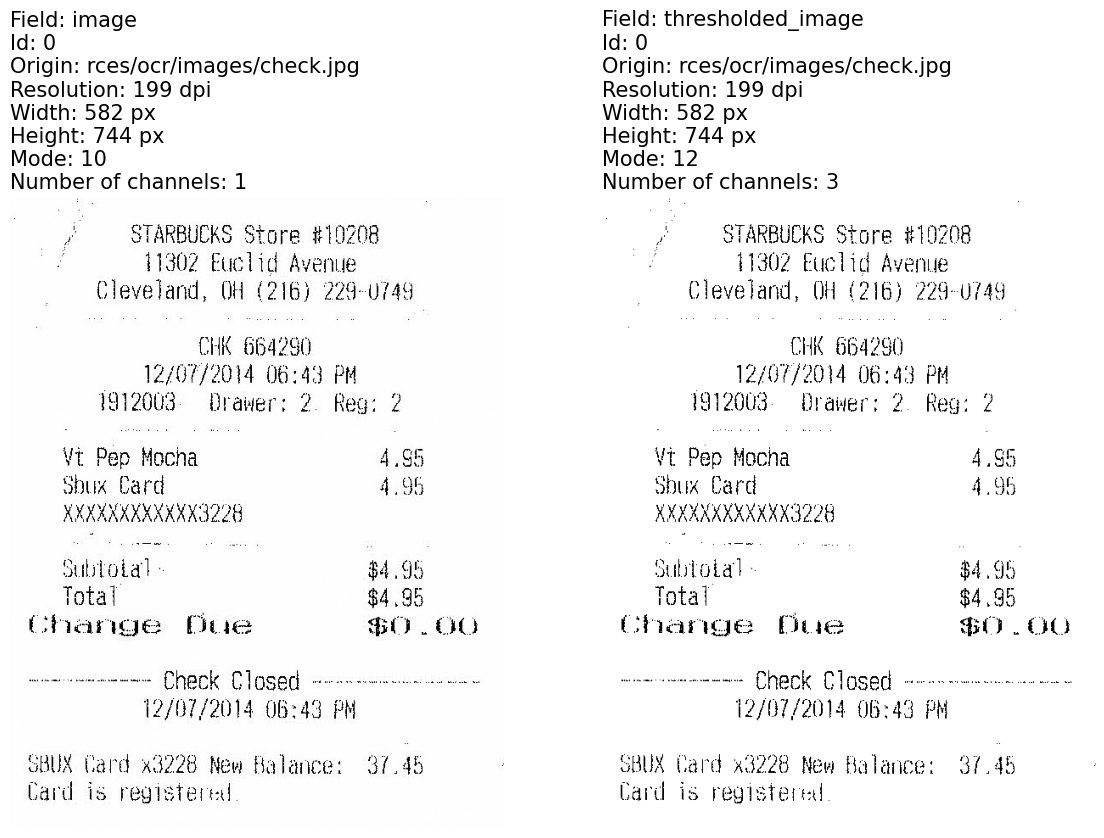

In [18]:
display_images_horizontal(result, "image,thresholded_image")

## Erosion

In [20]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

eroded = ImageTransformer() \
        .addErodeTransform(2,2)\
        .setInputCol("image") \
        .setOutputCol("eroded_image")

eroded_pipeline = PipelineModel(stages=[
    binary_to_image,
    eroded
])

In [22]:
result = eroded_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'eroded_image',
 'exception']

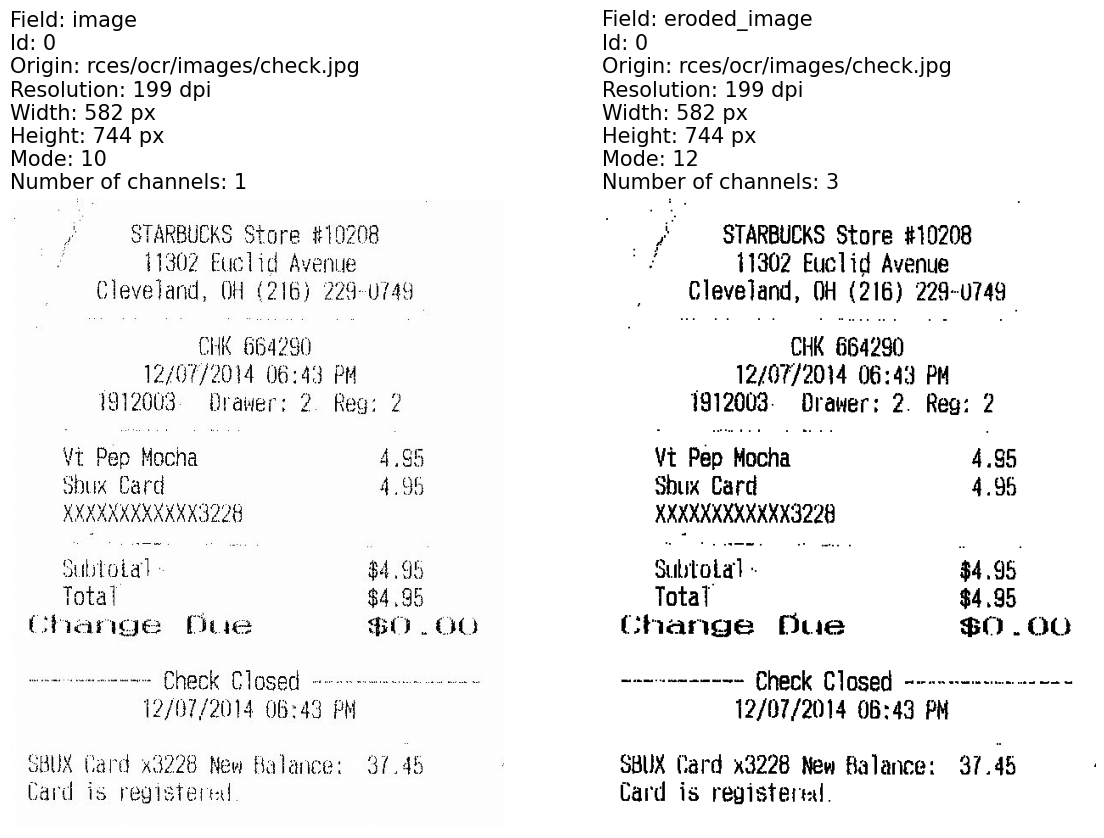

In [23]:
display_images_horizontal(result, "image,eroded_image")

## Dilation

In [24]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

dilated = ImageTransformer() \
        .addDilateTransform(1, 2)\
        .setInputCol("image") \
        .setOutputCol("dilated_image")

dilated_pipeline = PipelineModel(stages=[
    binary_to_image,
    dilated
])

In [25]:
result = dilated_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'dilated_image',
 'exception']

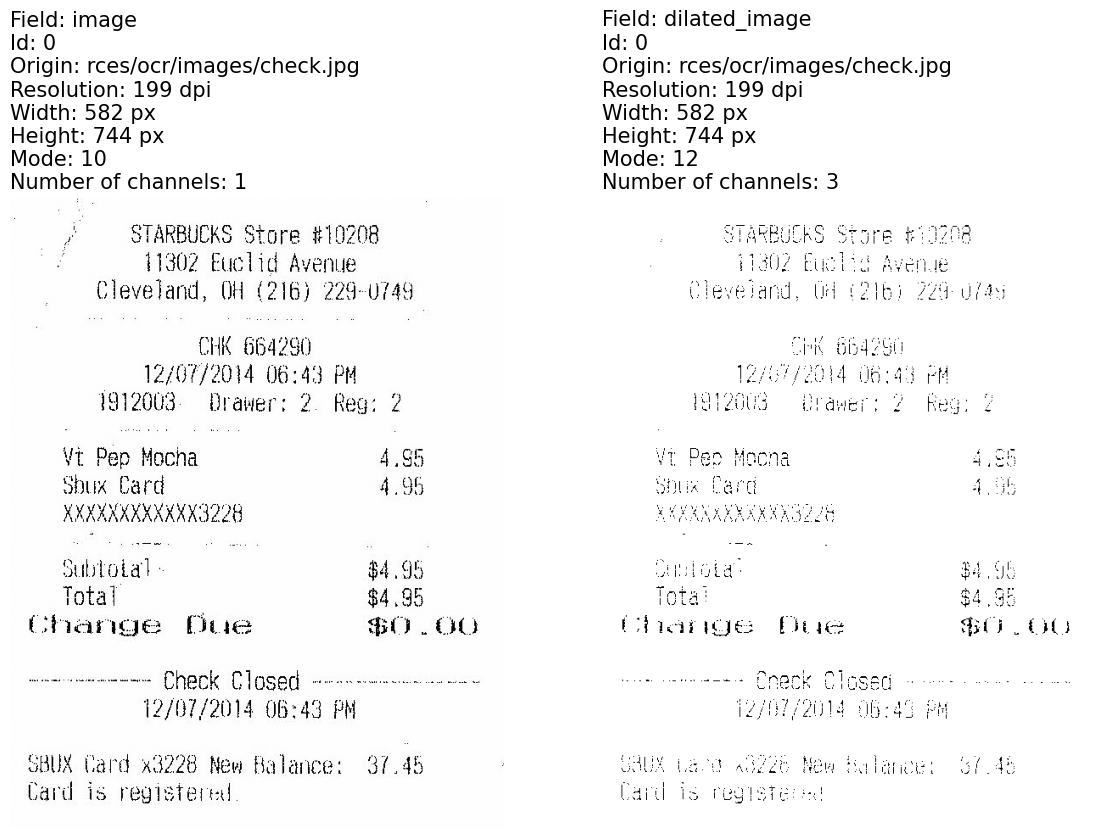

In [26]:
display_images_horizontal(result, "image,dilated_image")

## Remove Objects

In [28]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

corrected = ImageTransformer() \
        .addScalingTransform(2) \
        .addAdaptiveThreshold(31, 2)\
        .addRemoveObjects(10, 500) \
        .setInputCol("image") \
        .setOutputCol("corrected_image")

corrected_pipeline = PipelineModel(stages=[
    binary_to_image,
    corrected
])

In [29]:
result = corrected_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'corrected_image',
 'exception']

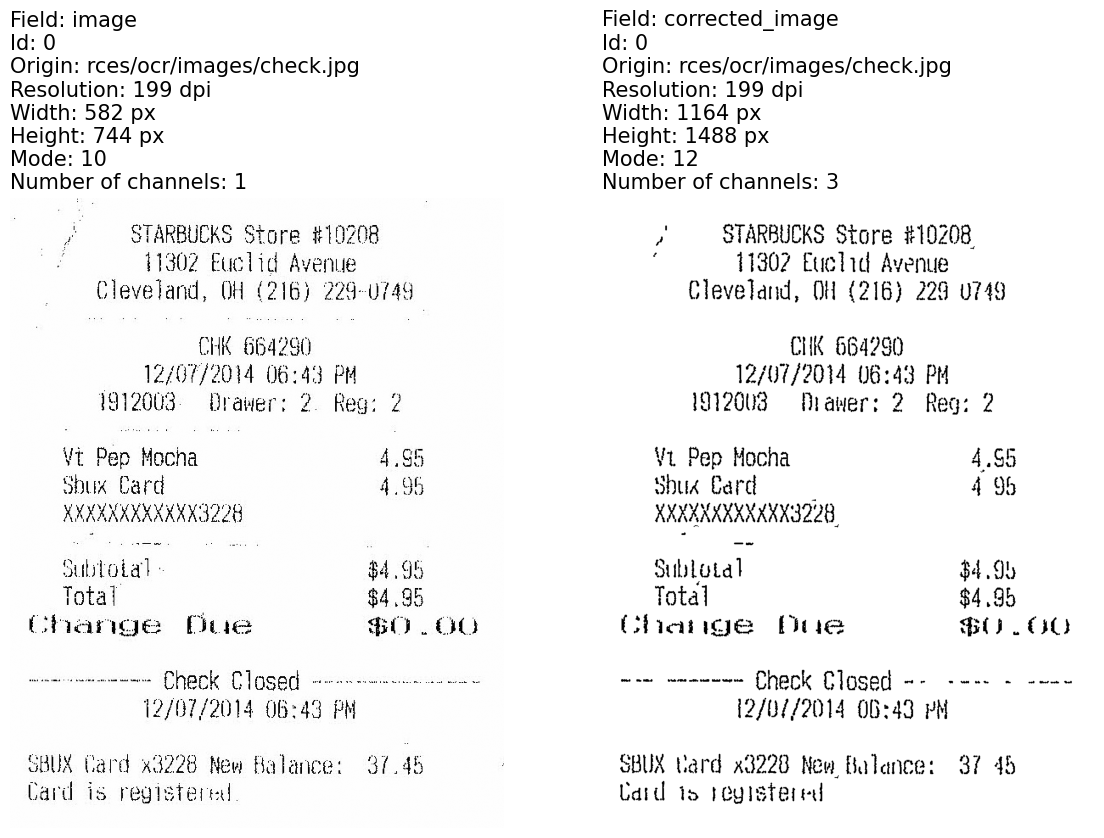

In [30]:
display_images_horizontal(result, "image,corrected_image")

## Median Blur

In [32]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

blured = ImageTransformer() \
    .addScalingTransform(2) \
    .addMedianBlur(3) \
    .setInputCol("image") \
    .setOutputCol("corrected_image")

blured_pipeline = PipelineModel(stages=[
    binary_to_image,
    blured
])

In [33]:
result = blured_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'corrected_image',
 'exception']

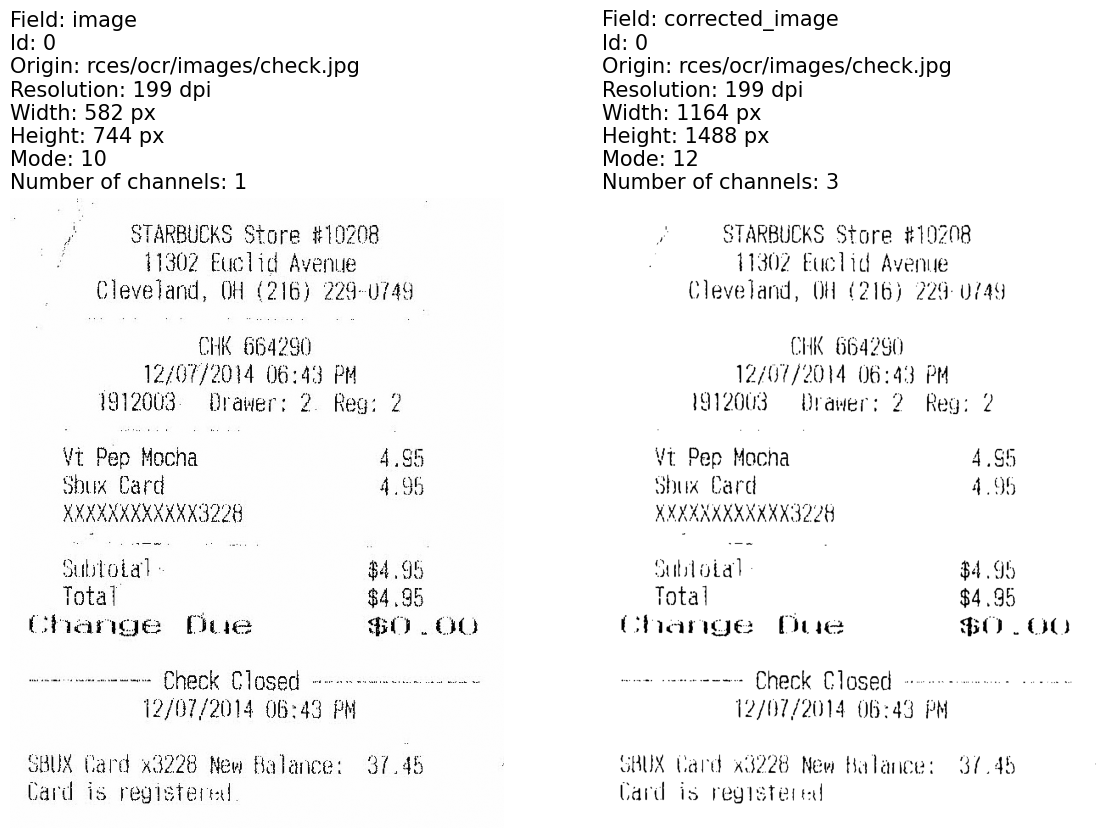

In [34]:
display_images_horizontal(result, "image,corrected_image")

## GPU Image transformation

In [37]:
binary_to_image = BinaryToImage()\
        .setInputCol("content") \
        .setOutputCol("image")

combined_ops = GPUImageTransformer() \
    .addScalingTransform(8) \
    .addOtsuTransform() \
    .addErodeTransform(3, 3) \
    .setInputCol("image") \
    .setOutputCol("multiple_ops_image")

combined_ops_pipeline = PipelineModel(stages=[
    binary_to_image,
    combined_ops
])

In [38]:
result = combined_ops_pipeline.transform(image_example_df)
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'multiple_ops_image',
 'exception']